## Analysis of the human version of Hk (KCNAB1 and KCNAB2) in inhibitory neurons from AD patients and controls

Authors: Yizhou Yu and Lillian Zhou, University of Cambridge 

Date: 31/07/2023

Load data (from https://cellxgene.cziscience.com/e/9813a1d4-d107-459e-9b2e-7687be935f69.cxg/)


### Data curation


In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import forestplot as fp
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import anndata as ad

In [2]:
def pp(path):
    adata = sc.read_h5ad(path)
    
    # Here, the feature names were set as ENS IDs, I changed it back to gene symbols
    adata.var['ENS_ID'] = adata.var_names
    adata.var_names = adata.var.feature_name
    adata.var_names_make_unique()
    
    #cell filtering
    # remove any potential empty features
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    mt_count_cutoff = np.quantile(adata.obs.pct_counts_mt, .98)
    
    print("mt_count_cutoff is: ", mt_count_cutoff)
    
    adata = adata[adata.obs.pct_counts_mt < mt_count_cutoff, :]
    
    n_genes_by_counts_cutoff = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    
    print("n_genes_by_counts_cutoff is: ", n_genes_by_counts_cutoff)
    
    adata = adata[adata.obs.n_genes_by_counts < n_genes_by_counts_cutoff, :]

    # log data 
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    
    # check highly variable genes 
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    adata.raw = adata
    
    #adata = adata[:, adata.var.highly_variable]
    #sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
    #sc.pp.scale(adata, max_value=10)
    
    # PCA, umap, leiden
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    
    sc.tl.leiden(adata)
    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(adata, init_pos='paga')
    
    results_file = path.split('.')[0] + "_processed.h5ad"
    
    adata.write(results_file)
    
    # Make QC figures 
    
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
    
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    
    return adata
    

mt_count_cutoff is:  2.5242989635467494
n_genes_by_counts_cutoff is:  4451.360000000001


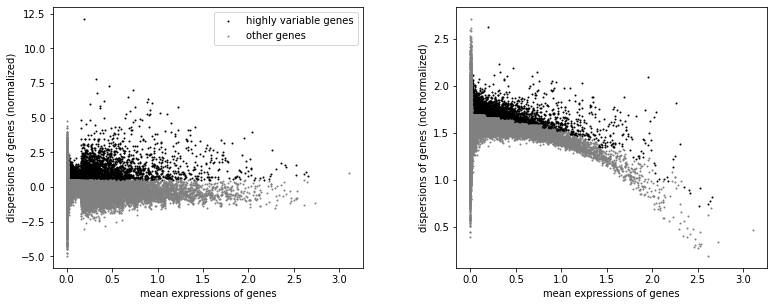

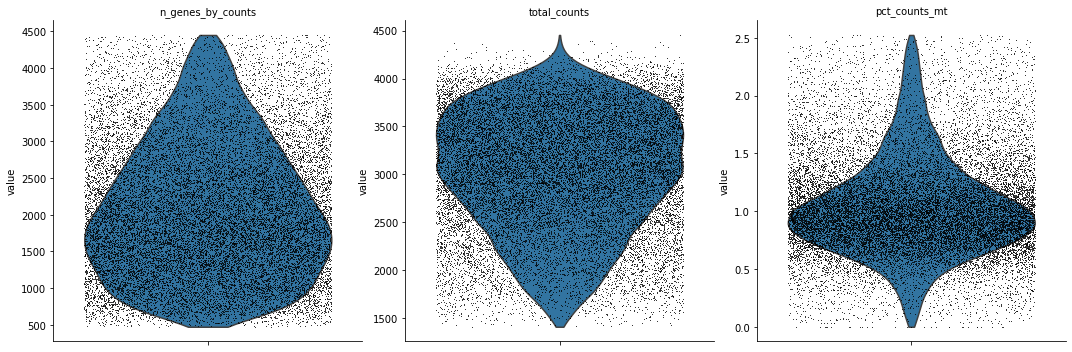

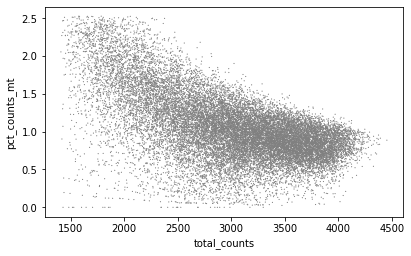

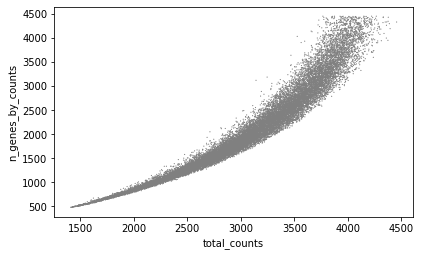

In [3]:
adata_OG = pp("dt/GSE129308.h5ad")

In [4]:
adata_OG.obs['Age']=adata_OG.obs['Age'].astype(int)
#adata_OG.var_names = adata_OG.var.feature_name

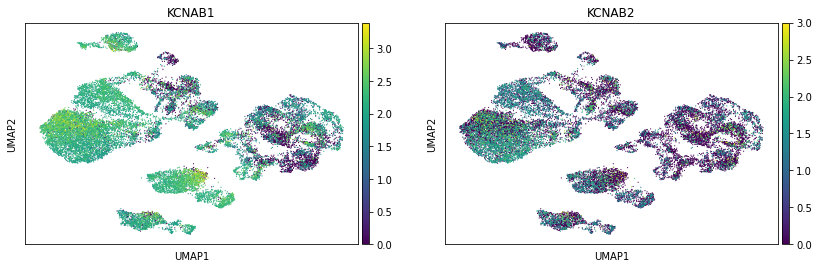

In [5]:
# Plot umap with regard to either gene

#['ENSG00000169282','ENSG00000069424'],title=['KCNAB1','KCNAB2'

sc.pl.umap(adata_OG,color=['KCNAB1','KCNAB2'],use_raw = True,
               title=['KCNAB1','KCNAB2'],save='_KCNAB.pdf')


In [6]:
adata_OG.obs[['Cell.Types', 'SORT', 'Amyloid', 'sex', 'self_reported_ethnicity']].describe()

,Cell.Types,SORT,Amyloid,sex,self_reported_ethnicity
count,22278,22278,22278,22278,22278
unique,7,3,3,2,4
top,In1_LHX6-PVALB,MAP2control,C3,male,unknown
freq,8632,10982,11296,13049,15128


In [7]:
adata_OG.obs['Amyloid'].unique()

['C3', 'No', 'DP (C0)']
Categories (3, object): ['C3', 'DP (C0)', 'No']

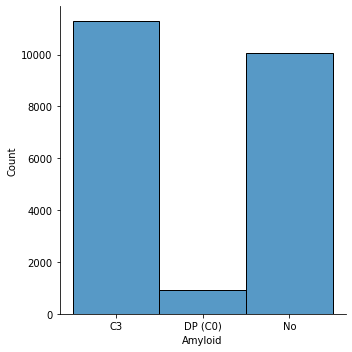

In [8]:
sns.displot(adata_OG.obs['Amyloid'])

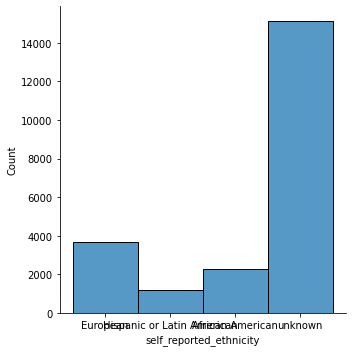

In [9]:
sns.displot(adata_OG.obs['self_reported_ethnicity'])

Most of the ethnicity is "unknown" so there is no point in analysing this.

The amyloid categories and the disease states are essentially the same, so I will not include that in the analyses.

### KCNAB1 Analysis

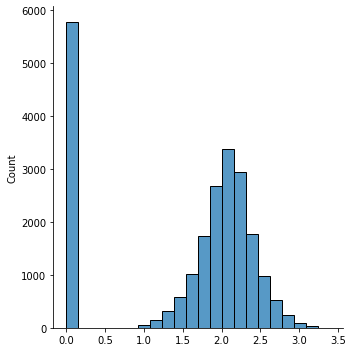

In [10]:
sns.displot(adata_OG[:,adata_OG.var.index=='KCNAB1'].X.toarray().flatten())

Remove all 0s in analyses since those cells are not expressing the gene

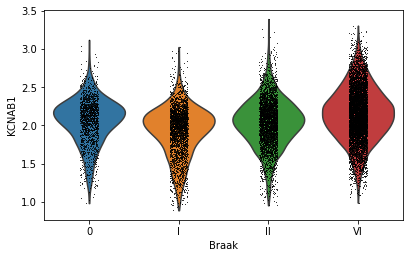


 MannwhitneyuResult(statistic=42063670.5, pvalue=1.5778939259814115e-158) 



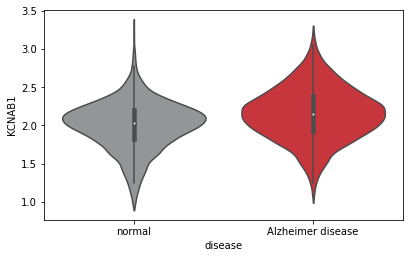

                                  Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 X         
No. Observations:                  16492                   Method:                             REML      
No. Groups:                        16                      Scale:                              0.0975    
Min. group size:                   546                     Log-Likelihood:                     -4257.2602
Max. group size:                   1764                    Converged:                          Yes       
Mean group size:                   1030.8                                                                
---------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------

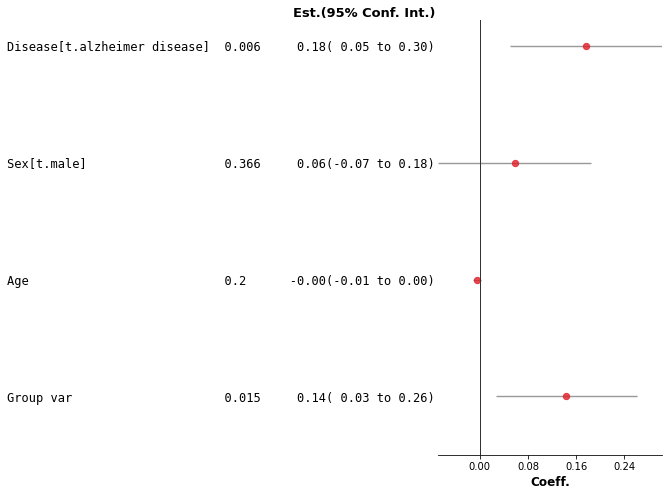

In [11]:
# KCNAB1

# slice data by gene
adata1=adata_OG[:,adata_OG.var.index=='KCNAB1']
df=adata1.obs.assign(X=adata1.X.toarray().flatten())
adata1=ad.AnnData(adata1.X,var=adata1.var,obs=df)
# slice cells expressing kcnab1
adata1=adata1[adata1.obs['X']>0,:]

# plot violin plot
sc.pl.violin(adata1, ['KCNAB1'], groupby='Braak')

mannW_test = stats.mannwhitneyu(adata1.obs[adata1.obs['disease'] == "Alzheimer disease"]['X'].values, 
                  adata1.obs[adata1.obs['disease'] == "normal"]['X'].values)

print( "\n",mannW_test, "\n")


sc.pl.violin(adata1, ['KCNAB1'], groupby='disease', 
                 palette=['#939598','#E01E27'],stripplot = False, inner='box',
                 order=['normal','Alzheimer disease'],save='KCNAB1_AD_violin.pdf')


# LMM
md=smf.mixedlm('X ~ C(disease, Treatment(reference="normal")) + Age + sex', data=adata1.obs, groups=adata1.obs['donor_id'])
mdf=md.fit(method=['Powell'])
print(mdf.summary())
# store lmm results
results=pd.DataFrame()
results.index=mdf.params.index
results['label']=['disease[T.Alzheimer disease]' if x=='C(disease, Treatment(reference="normal"))[T.Alzheimer disease]'  else x for x in mdf.params.index]
results['coef']=mdf.params
results['pval']=mdf.pvalues
results['pval3']=results['pval'].round(3)
results['lci']=mdf.conf_int()[0]
results['hci']=mdf.conf_int()[1]

# plot lmm results in forest plot
fp.forestplot(results[1:],
                 estimate='coef',
                 ll='lci',hl='hci',
                 varlabel='label',
                 annote=['pval3','est_ci'],
                 annoteheaders=['P-value','Est.(95% Conf. Int.)'],
                 capitalize="capitalize", #capitalize first letter of label
                 ylabel="Est.(95% Conf. Int.)",
                 xlabel='Coeff.',
                 **{"marker": "o",  # set maker symbol as circle
                 "markercolor": '#E01E27',  # adjust marker color
                 'linewidth':11, 
                })
plt.grid(False)
plt.savefig('KCNAB1.pdf', bbox_inches="tight")


 mannwhitneyu 
 MannwhitneyuResult(statistic=1981626.5, pvalue=2.6937127569955793e-49) 



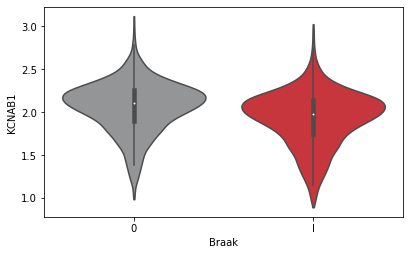

In [12]:
# linear regression

# expression decreases from braak stage 0 to 1
adata1_braak01=adata1[(adata1.obs['X']>0)&((adata1.obs['Braak']=='0')|(adata1.obs['Braak']=='I')),:]

mannW_test = stats.mannwhitneyu(adata1_braak01.obs[adata1_braak01.obs['Braak'] == "I"]['X'].values, 
                  adata1_braak01.obs[adata1_braak01.obs['Braak'] == "0"]['X'].values)

print( "\n mannwhitneyu \n",mannW_test, "\n")



sc.pl.violin(adata1_braak01, ['KCNAB1'], 
             groupby='Braak', 
             palette=['#939598','#E01E27'],stripplot = False, inner='box',
            save = "KCNAB1_braak01.pdf")


                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     135.7
Date:                Wed, 02 Aug 2023   Prob (F-statistic):           1.96e-84
Time:                        11:00:57   Log-Likelihood:                -1138.2
No. Observations:                4841   AIC:                             2284.
Df Residuals:                    4837   BIC:                             2310.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3806      0.123      3.105      

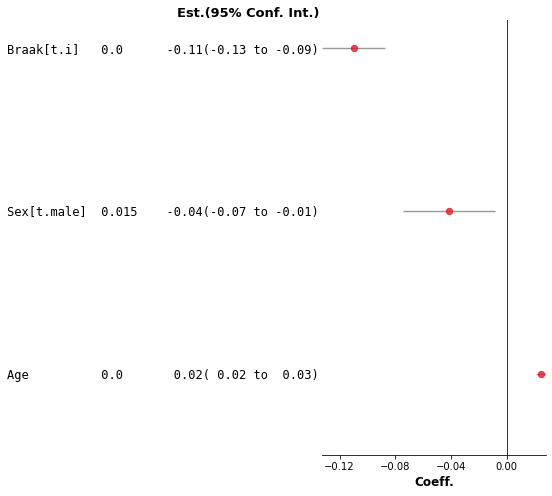

In [13]:
model=smf.ols('X ~  Braak + Age + sex', data=adata1_braak01.obs).fit()
print(model.summary())

# store ols results
results=pd.DataFrame()
results.index=model.params.index
results['label']=model.params.index
results['coef']=model.params
results['pval']=model.pvalues
results['pval3']=results['pval'].round(3)
results['lci']=model.conf_int()[0]
results['hci']=model.conf_int()[1]

# plot lmm results in forest plot
fp.forestplot(results[1:],
                 estimate='coef',
                 ll='lci',hl='hci',
                 varlabel='label',
                 annote=['pval3','est_ci'],
                 annoteheaders=['P-value','Est.(95% Conf. Int.)'],
                 capitalize="capitalize", #capitalize first letter of label
                 ylabel="Est.(95% Conf. Int.)",
                 xlabel='Coeff.',
                 **{"marker": "o",  # set maker symbol as circle
                 "markercolor": '#E01E27',  # adjust marker color
                 'linewidth':11, 
                })
plt.grid(False)
plt.savefig('KCNAB1_braak_lm.pdf', bbox_inches="tight")

### KCNAB2 Analysis


 mannwhitneyu 
 MannwhitneyuResult(statistic=8368052.0, pvalue=2.697765469421218e-148) 



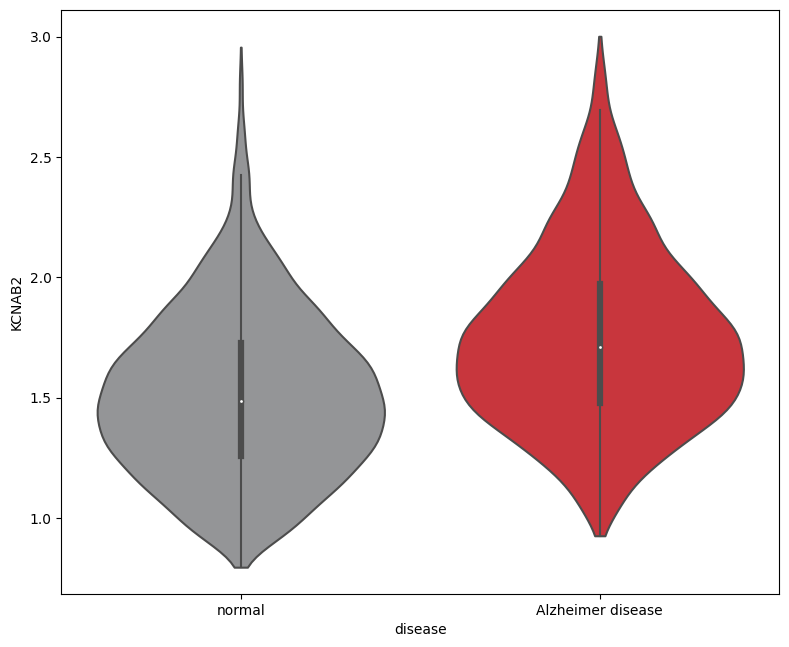

                                  Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 X         
No. Observations:                  7140                    Method:                             REML      
No. Groups:                        16                      Scale:                              0.0946    
Min. group size:                   204                     Log-Likelihood:                     -1761.7573
Max. group size:                   1013                    Converged:                          Yes       
Mean group size:                   446.2                                                                 
---------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------

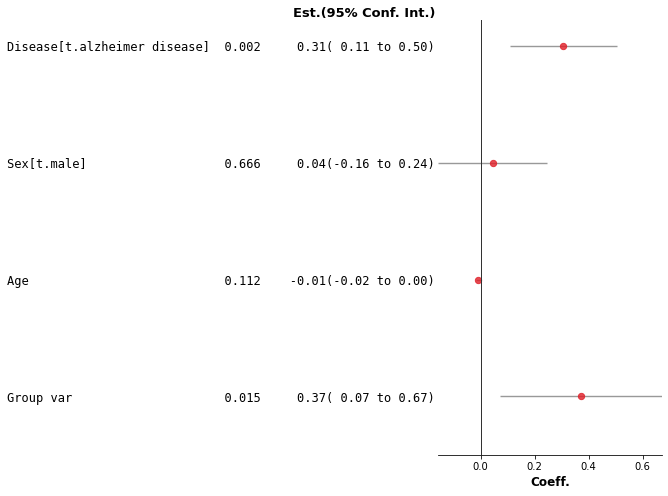

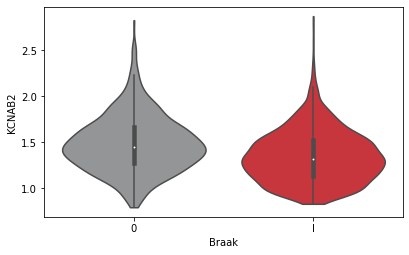

                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     58.07
Date:                Wed, 02 Aug 2023   Prob (F-statistic):           3.10e-36
Time:                        11:00:58   Log-Likelihood:                -417.89
No. Observations:                2396   AIC:                             843.8
Df Residuals:                    2392   BIC:                             866.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9367      0.163      5.750      

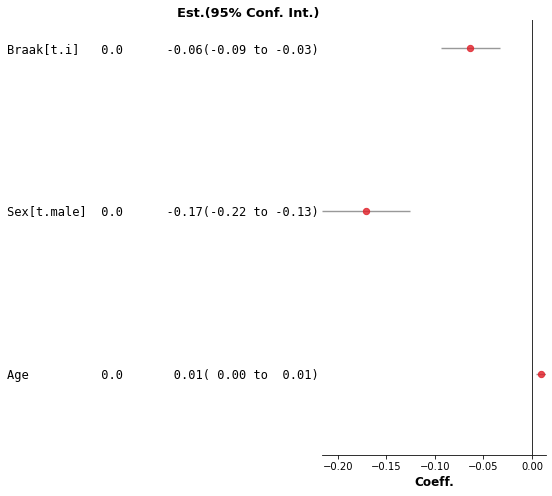

In [14]:
# KCNAB2

# slice data by gene
adata2=adata_OG[:,adata_OG.var.index=='KCNAB2']
df=adata2.obs.assign(X=adata2.X.toarray().flatten())
adata2=ad.AnnData(adata2.X,var=adata2.var,obs=df)
# slice cells expressing kcnab1
adata2=adata2[adata2.obs['X']!=0,:]

mannW_test = stats.mannwhitneyu(adata2.obs[adata2.obs['disease'] == "Alzheimer disease"]['X'].values, 
                  adata2.obs[adata2.obs['disease'] == "normal"]['X'].values)

print( "\n mannwhitneyu \n",mannW_test, "\n")

# plot violin plot
with plt.rc_context({"figure.figsize": (8,8), "figure.dpi": (100)}):
    sc.pl.violin(adata2, ['KCNAB2'], groupby='disease', 
                 palette=['#939598','#E01E27'],stripplot = False, inner='box',
                 order=['normal','Alzheimer disease'],save='KCNAB2_violin.pdf')

# LMM
md=smf.mixedlm('X ~  Age + C(disease, Treatment(reference="normal")) + sex', data=adata2.obs, groups=adata2.obs['donor_id'])
mdf=md.fit(method=['Powell'])
print(mdf.summary())
# store lmm results
results=pd.DataFrame()
results.index=mdf.params.index
results['label']=['disease[T.Alzheimer disease]' if x=='C(disease, Treatment(reference="normal"))[T.Alzheimer disease]'  else x for x in mdf.params.index]
results['coef']=mdf.params
results['pval']=mdf.pvalues
results['pval3']=results['pval'].round(3)
results['lci']=mdf.conf_int()[0]
results['hci']=mdf.conf_int()[1]
# plot lmm results in forest plot
fp.forestplot(results[1:],
                 estimate='coef',
                 ll='lci',hl='hci',
                 varlabel='label',
                 annote=['pval3','est_ci'],
                 annoteheaders=['P-value','Est.(95% Conf. Int.)'],
                 capitalize="capitalize", #capitalize first letter of label
                 ylabel="Est.(95% Conf. Int.)",
                 xlabel='Coeff.',
                 **{"marker": "o",  # set maker symbol as circle
                 "markercolor": '#E01E27',  # adjust marker color
                 'linewidth':11, 
                })
plt.grid(False)
plt.savefig('KCNAB2.pdf', bbox_inches="tight")

# linear regression
# expression decreases from braak stage 0 to 1
adata2_braak01=adata2[(adata2.obs['X']>0)&((adata2.obs['Braak']=='0')|(adata2.obs['Braak']=='I')),:]


mannW_test = stats.mannwhitneyu(adata2_braak01.obs[adata2_braak01.obs['Braak'] == "I"]['X'].values, 
                  adata2_braak01.obs[adata2_braak01.obs['Braak'] == "0"]['X'].values)

print( "\n mannwhitneyu \n",mannW_test, "\n")

sc.pl.violin(adata2_braak01, ['KCNAB2'], 
             groupby='Braak', 
             palette=['#939598','#E01E27'],stripplot = False, inner='box',
            save = "KCNAB2_braak01.pdf")

model=smf.ols('X ~  Braak + Age + sex', data=adata2_braak01.obs).fit()
print(model.summary())



# store ols results
results=pd.DataFrame()
results.index=model.params.index
results['label']=model.params.index
results['coef']=model.params
results['pval']=model.pvalues
results['pval3']=results['pval'].round(3)
results['lci']=model.conf_int()[0]
results['hci']=model.conf_int()[1]

# plot lmm results in forest plot
fp.forestplot(results[1:],
                 estimate='coef',
                 ll='lci',hl='hci',
                 varlabel='label',
                 annote=['pval3','est_ci'],
                 annoteheaders=['P-value','Est.(95% Conf. Int.)'],
                 capitalize="capitalize", #capitalize first letter of label
                 ylabel="Est.(95% Conf. Int.)",
                 xlabel='Coeff.',
                 **{"marker": "o",  # set maker symbol as circle
                 "markercolor": '#E01E27',  # adjust marker color
                 'linewidth':11, 
                })
plt.grid(False)
plt.savefig('KCNAB2_braak_lm.pdf', bbox_inches="tight")


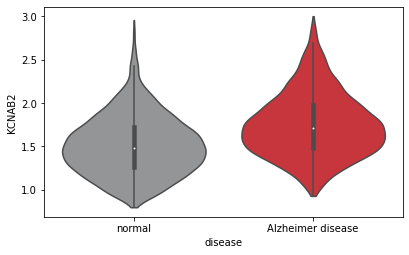

In [16]:
sc.pl.violin(adata2, ['KCNAB2'], groupby='disease', 
                 palette=['#939598','#E01E27'],stripplot = False, inner='box',
                 order=['normal','Alzheimer disease'],save='KCNAB2_violin.pdf')